<div style="background-image:url(fond.jpeg);">
<br>
<br>
<font size="15pt" style="color:#6B86BF">Projet<br><br>Machine Learning</font>
<br>
<br>
<i><font size="3pt" style="color:#3A5989"> Linda DINGUIR<br>
Pierre PAPELARD</font></i>
<br>
<br>
<br>
<h1 style="color:#3A5989"> Table des matières</h1><br>
<font size="4pt" style="color:#3A5989">
<ol start="1">
    <li>Présentation de notre jeu de données</li>
    <li>Analyse préliminaire des données</li>
    <li>Encodage des variables catégorielles</li>
    <li>Le choix de notre métrique</li>
    <li>Apprentissage supervisé
        <ol>
            <li>Méthode non paramétriques
                <ol>
                    <li>Méthode des k plus proches voisins</li>
                    <li>Arbre de décision</li>
                    <li>Random forests</li>
                </ol>
            </li>
            <li>Méthode paramétriques</li>
        </ol>
    </li>
    <li>Réseau de neurones</li>
    <li>Conclusion</li>
</ol>
</font>
</div>

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, time, itertools
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, average_precision_score, brier_score_loss, f1_score, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold, GridSearchCV, train_test_split
from numpy import mean, std


<h2 style="color:#6B86BF">Présentation de notre jeu de données</h2>

In [2]:
data = pd.read_csv('bank-additional-full.csv', sep=';').rename(str.title, axis=1)
print ("Le train set contient", len(data), "lignes pour", len(data.columns), "colonnes")
data.head()

Le train set contient 41188 lignes pour 21 colonnes


,Age,Job,Marital,Education,Default,Housing,Loan,Contact,Month,Day_Of_Week,...,Campaign,Pdays,Previous,Poutcome,Emp.Var.Rate,Cons.Price.Idx,Cons.Conf.Idx,Euribor3M,Nr.Employed,Y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


<h2 style="color:#6B86BF">Analyse préliminaire des données</h2>

<h2 style="color:#6B86BF">Encodage des variables catégorielles</h2>

La plupart des algorithmes vus en cours prennent des valeurs numériques en entrée. Il nous faut donc trouver une façon de transformer nos modalités en données numériques. 


Pour ce faire, nous avons choisi d'utiliser la technique d’encodage **one-hot encoding**.</br>

<i style="color:#5CB27A">Comment ça fonctionne ?</i></br>

Prenons la variables catégorique **Marital** qui admet 4 modalités **'divorced'**, **'married'**, **'single'** et **'unknown'**.</br>
Le **one-hot encoding** consiste à créer 4 variables représantant chacune les 4 modalités.</br>

Ici, la nouvelle variable **'divorced'** aura des **0** partout et des **1** à la position où l'individu est divorcé.</br>
En effet, plutot que d'avoir une variable à N modalités, on aura N variables numériques exprimant dans notre exemple si oui ou non (1 ou 0) l'individu est 'divorced' (respectivement 'married', 'single' et 'unknown').

In [27]:
Encoded_Data = pd.get_dummies(data,columns=['Marital','Job', 'Loan', 'Housing', 'Education', 'Poutcome', 'Default','Contact'],drop_first=True)
Encoded_Data.Y = data.Y.apply(lambda y :int(y=='yes'))
Encoded_Data['Month']= Encoded_Data['Month'].replace(['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'],[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
Encoded_Data['Day_Of_Week']= Encoded_Data['Day_Of_Week'].replace(['mon','tue','wed','thu','fri'],[1, 2, 3, 4, 5])
Encoded_Data.head()

,Age,Month,Day_Of_Week,Duration,Campaign,Pdays,Previous,Emp.Var.Rate,Cons.Price.Idx,Cons.Conf.Idx,...,Education_high.school,Education_illiterate,Education_professional.course,Education_university.degree,Education_unknown,Poutcome_nonexistent,Poutcome_success,Default_unknown,Default_yes,Contact_telephone
0,56,5,1,261,1,999,0,1.1,93.994,-36.4,...,0,0,0,0,0,1,0,0,0,1
1,57,5,1,149,1,999,0,1.1,93.994,-36.4,...,1,0,0,0,0,1,0,1,0,1
2,37,5,1,226,1,999,0,1.1,93.994,-36.4,...,1,0,0,0,0,1,0,0,0,1
3,40,5,1,151,1,999,0,1.1,93.994,-36.4,...,0,0,0,0,0,1,0,0,0,1
4,56,5,1,307,1,999,0,1.1,93.994,-36.4,...,1,0,0,0,0,1,0,0,0,1


La limite de cet encodage est que le nombre de variable augmente aussi : on passe de **21** variables à **54**.</br>
Certains algorithmes peuvent en effet avoir plus de difficultés à bien prédire lorsque le nombre de modalités est trop grand.</br>

Cependant, nous avons pensé judicieux d'utiliser cette méthode plutôt qu'un **encodage ordinal** (attribuer un rang à nos modalité comme par exemple 'divorced' = 1, 'married' = 2, 'single' = 3 et 'unknown' = 4) car nos variables n'ont pas de notion d’ordre.

<h2 style="color:#6B86BF">Le choix de notre métrique</h2>

Comme nous l'avons vu précedement, nous avons affaire à des **données déséquilibrées**. </br>
Nous sommes face à un problème de classification où l’échantillon d’apprentissage contient une forte disparité entre les classes à prédire (**..%** de yes contre **..%** de no).</br>

<i style="color:#5CB27A">Compte tenu de ce déséquilibre, est-il judicieux d'utiliser **l'accuracy** (le taux de bonnes prédictions) ?</i></br>

Imaginons que l'on choisisse un algorithme qui classe chaque exemple dans la classe majoritaire c'est-à-dire qui prédise simplement **"no"** pour tous les individus. Dans ce cas nous auront un taux de bonnes prédictions égale à ..%.</br>
Le modèle semblera performant mais cela ne sera que le reflet de la surreprésentation de la classe majoritaire.</br>

Dans notre cas l'objectif est de prédire si le client va souscrire à un dépôt à terme. C'est donc la classe minoritaire que l’on aimerait pouvoir identifier.

<h2 style="color:#6B86BF">Méthode des k plus proches voisins kNN</h2>


Cette approche consiste à étudier les **voisins les plus proches** du point que l'on souhaite prédire.</br> 

On cherche à estimer l'output $y \in \{0 ,1\}$ associé à l'input $X \in \mathbb{R}^d$ en selectionnant $K$ individus dont les inputs sont les plus proches de $X$ dans nos données d'entrainement (X_train).</br>
On entend par "voisins les plus proches" les inividus ayant les **distances** les plus petites de notre input X.</br>


Dans notre problème de classification, on retiendra la classe la plus représentée parmi les $K$ outputs associées aux $K$ inputs les plus proches de la nouvelle entrée $X$.</br>
Ainsi on définit notre classifier $g_n(x)$ tel que :
$$ g_n(X) = \left\{
    \begin{array}{ll}
        1 & \sum_{i = 1}^{k} \frac{1}{k} y_{(i)}(X) > \frac{1}{2} \\
        0 & \mbox{sinon.}
    \end{array}
\right.
$$
où :</br>
$(X_{(1)}(X), y_{(1)}(X)), ..., (X_{(n)}(X), y_{(n)}(X))$ est la permutation des couples $((X_{1}, y_{1}), ..., (X_{n}, y_{n}))$ de X_train de sorte à ce que notre nouvel arrangement soit ordonné de manière à avoir des **distances** croissantes par rapport à notre input X : $||X_j - x||, i.e. ||X_{(1)} - x|| \leq ... \leq ||X_{(n)} - x||$ </br>

Un question que l'on peut se poser est : <i style="color:#5CB27A">Quel **K** allons nous choisir ?</i></br>
On peut aller plus loin et se demander : <i style="color:#5CB27A">Quelle **mesure de distance** reflète le mieux la proximité entre deux variables ?</i></br>

En effet, il existe plusieurs mesures de distance : </br>
**Distance euclidienne** : $ d(X, X') = \sqrt{\sum_{i = 1}^{n} (X_i - X_i')^2} $
</br>
**Distance de Manhattan** : $ d(X, X') = (\sum_{i = 1}^{n} |X_i - X_i'|) $
</br>
**Distance de Minkowski** : $ d(X, X') = (\sum_{i = 1}^{n} |X_i - X_i'|)^{\frac{1}{p}} $
</br>
</br>
$\Longrightarrow$ **K** et la **mesure de distance** sont les deux **hyper-paramètres** de notre modèle.
</br>

<i style="color:#5CB27A">Comment calculer la valeur optimale de nos **hyperp-aramètres** ?</i>

$\Longrightarrow$ Nous allons réaliser une **validation-croisée**  afin d'optimiser les hyper-paramètres de l'algorithme.

In [4]:
X = (Encoded_Data.copy()).drop(['Y'], axis=1)
y = Encoded_Data.Y.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

In [5]:
NumberOfFolds = 5

hyper_param_grid = {"n_neighbors" : [5, 7, 9, 11, 13, 15, 17, 20], "metric" : ["euclidean", "manhattan", "minkowski"]}

kf = StratifiedKFold(n_splits=NumberOfFolds, shuffle = True)

# Creation d'une "GridSearch" à la main : 
# Une liste de liste contenant un classifieur de KNN avec en indice i le nombre de voisins et en j la metrique choisie
clf_grid = []
CV_grid = []
for i in hyper_param_grid["n_neighbors"]:
    tmp_clf = []
    tmp_CV = []
    for j in hyper_param_grid["metric"]:
        clf = KNeighborsClassifier(n_neighbors = i, metric = j)
        tmp_clf.append(clf)
        CV = cross_val_score(clf, X_train, y_train, scoring = 'f1', cv = kf, n_jobs = -1)
        tmp_CV.append(np.mean(CV))
    clf_grid.append(tmp_clf)
    CV_grid.append(tmp_CV)

CV_grid_df = pd.DataFrame(CV_grid, columns = ["Euclidean", "Manhattan", "Minkowski"], index =  [5, 7, 9, 11, 13, 15, 17, 20])
CV_grid_df

,Euclidean,Manhattan,Minkowski
5,0.524086,0.536778,0.524889
7,0.536075,0.535483,0.537342
9,0.541797,0.536130,0.536585
11,0.541156,0.541503,0.537653
13,0.536515,0.548220,0.540111
15,0.543205,0.546837,0.529971
17,0.543460,0.548610,0.544471
20,0.521900,0.524766,0.519206


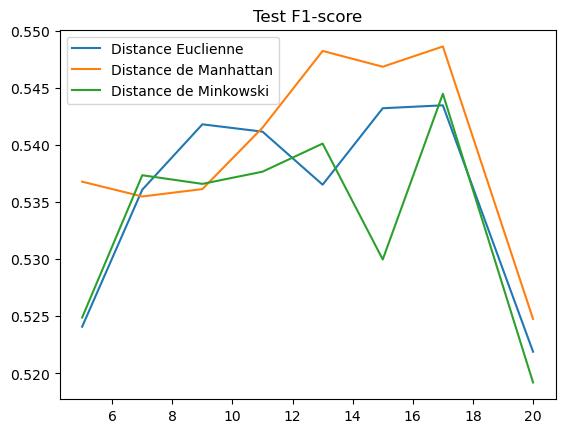

In [6]:
plt.plot([5, 7, 9, 11, 13, 15, 17, 20], CV_grid_df["Euclidean"], label="Distance Euclienne")
plt.plot([5, 7, 9, 11, 13, 15, 17, 20], CV_grid_df["Manhattan"], label="Distance de Manhattan")
plt.plot([5, 7, 9, 11, 13, 15, 17, 20], CV_grid_df["Minkowski"], label="Distance de Minkowski")
plt.legend()
plt.title("Test F1-score")
plt.show()

Au vu des résultats de la **validation croisée** nous avons choisi les hyper-paramètres suivants de sorte à **maximiser** le F1-score de notre modèle:</br>

In [7]:
n = np.argmax(CV_grid)
score = np.array(CV_grid).flatten()[n]
KNN = np.array(clf_grid).flatten()[n]
KNN.fit(X_train, y_train)

print("Nombre de voisons : k = ", hyper_param_grid["n_neighbors"][n//3])
print("Mesure de distance : ", hyper_param_grid["metric"][n%3])
print("Crossval F1-score score : ", score)
print("Test accuracy : ", KNN.score(X_test, y_test))


Nombre de voisons : k =  17
Mesure de distance :  manhattan
Crossval F1-score score :  0.5486098451550045
Test accuracy :  0.9106535884238127


### Phase de prédiction :  

In [8]:
y_pred = KNN.predict(X_test)

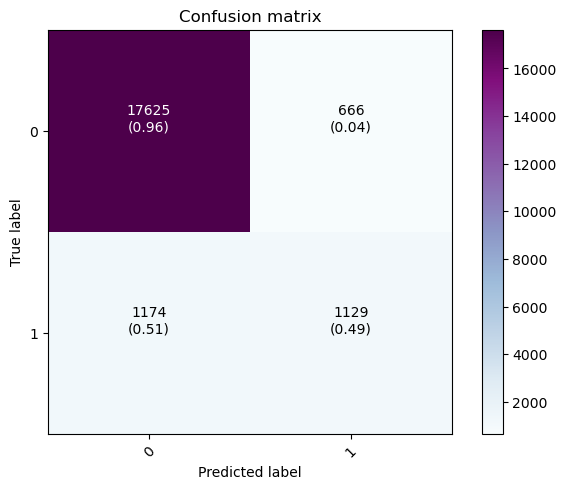

In [11]:
def plot_matrice_confusion(y_test, y_pred):
    CM = confusion_matrix(y_test, y_pred)

    plt.imshow(CM, interpolation='nearest', cmap=plt.cm.BuPu)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(np.unique(y_test)))
    plt.xticks(tick_marks, np.unique(y_test), rotation=45)
    plt.yticks(tick_marks, np.unique(y_test))
    thresh = CM.max() / 2.

    for i, j in itertools.product(range(CM.shape[0]), range(CM.shape[1])):
        plt.text(j, i, format(CM[i, j], 'd')+"\n("+format(((CM / CM.sum(axis=1)[:, np.newaxis])[i, j]), '.2f')+")", horizontalalignment="center", color="white" if CM[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_matrice_confusion(y_test, y_pred)

In [12]:
# Commenter matrice de confusion et commenter
#dire que pas bon resultats avec ce modele
#It’s a non-parametric method: it suffers from the curse of dimensionality!
#to use when the number of variables p is reasonable compared to the number of observations etc ...
#BLABLA

$$\textrm{MSE} =\frac{1}{n}\sum_{i=1}^{n}(Y_{i}-{\hat{Y_{i}}})^{2}$$

In [15]:
MSE = mean_squared_error(y_test, y_pred)
print("MSE : ", MSE)

MSE :  0.08934641157618724


In [16]:
# overfitting ?? under fitting ?? Erreur de generalisation, MSE ...
# Appronfondir ici

<h2 style="color:#6B86BF">Arbres de décision (CART)</h2> <img src="Tree.jpeg" width=15% height=15%/>


Le principe de cette méthode est de partitionner l'espace $\mathbb{R}^d$ en plusieurs "cellules" $A_1, A_2,$ ... de telle sorte à expliquer l'output $y$ **par vote majoritaire sa cellule de provenance**.</br>
On définit notre classifier $g_n(X)$ tel que :
$$ g_n(X) = \left\{
    \begin{array}{ll}
        1 & \sum_{i = 1}^{k} \mathbb{1}_{X_i \in A(X)}\mathbb{1}_{Y_i = 1} > \sum_{i = 1}^{k} \mathbb{1}_{X_i \in A(X)}\mathbb{1}_{Y_i = 0} \\
        0 & \mbox{sinon.}
    \end{array}
\right.
$$
où :</br>

In [34]:
# notes : 

#We will focus on the CART algorithm which is the most widely used algorithm to define trees.
#CART = Classification and Regression Trees

#Tree partition :
#Find a partition of the feature space into a set of rectangles which separates blue points from red points

#CART algorithm propose to restrict attention to recursive binary partitions.
#At each step, the method split the data into two regions according to a split variable and a split point.
#At the end, we do a majority vote in each cell of the partition (in each rectangle).

# Rajouter des explications sur cette partie

In [24]:
NumberOfFolds = 5

hyper_param_grid = {"max_depth" : np.arange(2, 15), "critere" : ["gini", "entropy"]}

kf = StratifiedKFold(n_splits=NumberOfFolds, shuffle = True)

clf_grid = []
CV_grid = []
for i in hyper_param_grid["max_depth"]:
    tmp_clf = []
    tmp_CV = []
    for j in hyper_param_grid["critere"]:
        clf = DecisionTreeClassifier(max_depth = i, criterion = j)
        tmp_clf.append(clf)
        CV = cross_val_score(clf, X_train, y_train, scoring = 'f1', cv = kf, n_jobs = -1)
        tmp_CV.append(np.mean(CV))
    clf_grid.append(tmp_clf)
    CV_grid.append(tmp_CV)

CV_grid_df = pd.DataFrame(CV_grid, columns = ["Gini", "Entropy"], index =  np.arange(2, 15))
CV_grid_df

,Gini,Entropy
2,0.488013,0.495545
3,0.584139,0.529011
4,0.550482,0.545230
5,0.541260,0.567043
6,0.571318,0.537252
7,0.573385,0.542368
8,0.539216,0.563580
9,0.532611,0.546647
10,0.543098,0.545063
11,0.536514,0.551636


Text(0, 0.5, 'Score F1')

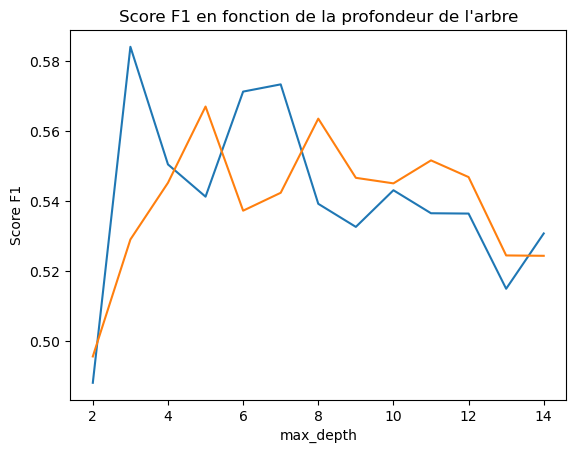

In [25]:
plt.plot(np.arange(2, 15), CV_grid_df["Gini"], label="Critère de Gini")
plt.plot(np.arange(2, 15), CV_grid_df["Entropy"], label="Critère d'Entropy")

plt.title("Score F1 en fonction de la profondeur de l'arbre")
plt.xlabel("max_depth")
plt.ylabel("Score F1")

Les **hyper-paramètres optimaux** :

Profondeur maximale de l'arbre :  3
critère :  gini
Crossval F1-score score :  0.5841391247108266
Test accuracy :  0.9079343498106245


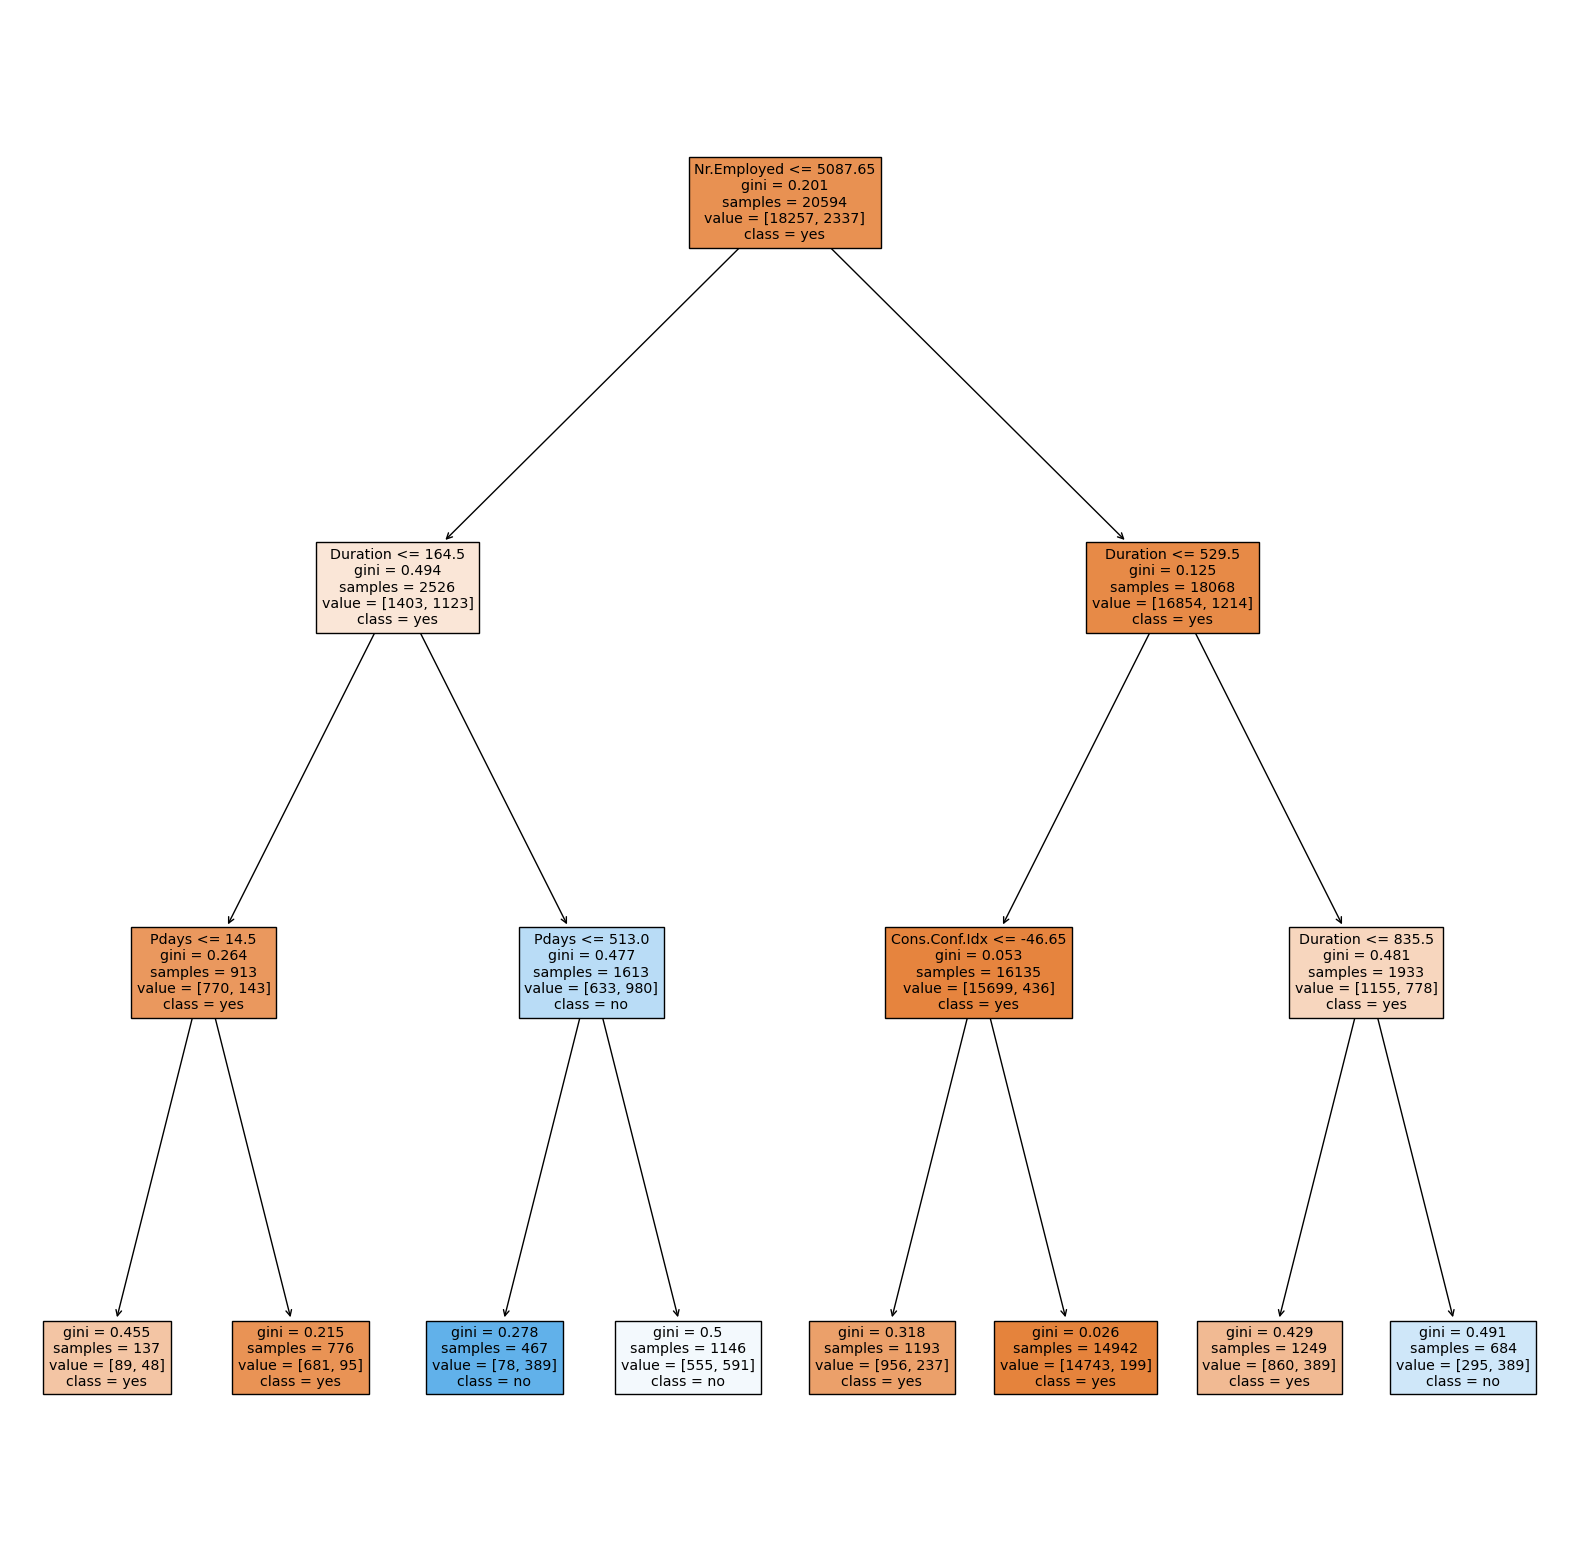

In [29]:
n = np.argmax(CV_grid)
score = np.array(CV_grid).flatten()[n]
TREE = np.array(clf_grid).flatten()[n]
TREE.fit(X_train, y_train)

print("Profondeur maximale de l'arbre : ", hyper_param_grid["max_depth"][n//2])
print("critère : ", hyper_param_grid["critere"][n%2])
print("Crossval F1-score score : ", score)
print("Test accuracy : ", TREE.score(X_train, y_train))


plt.figure(figsize=(20,20))
tree.plot_tree(TREE, filled = True, class_names=['yes', 'no'], feature_names=X.columns) # A verifier si jene me suis pas trompee de sens dans yes et no
plt.show()

### Phase de prédiction :  

In [30]:
y_pred = TREE.predict(X_test)
TREE.score(X_test, y_test)

0.9092454112848403

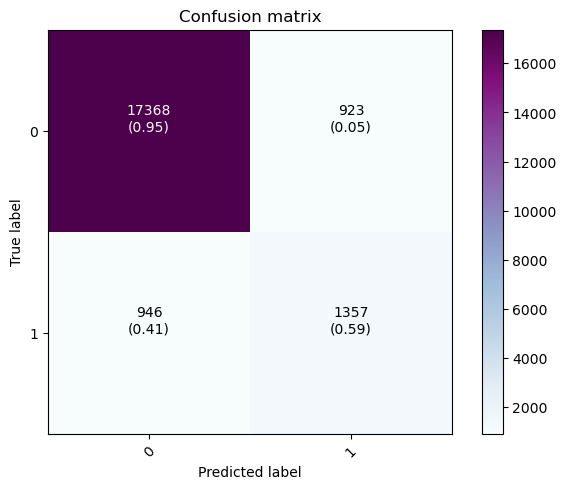

In [31]:
plot_matrice_confusion(y_test, y_pred)

In [32]:
MSE = mean_squared_error(y_test, y_pred)
print("MSE : ", MSE)

MSE :  0.09075458871515976


In [33]:
## Commenter matrice de confusion
# Commenter MSE 
## BLABLA

<h2 style="color:#6B86BF">Random forests</h2>